$$
\newcommand{\M}{\mathcal{M}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\yhat}{\mathbf{\hat{y}}}
\newcommand{\iou}{\textbf{IOU}}
$$

## Data Collection and Label

### Original Dataset

- 500 images of size $4032 \times 3024$ provided by LTA:
    - 150 positive class 1 where 1 means defective;
    - 350 negative class 0 where 0 means non-defective;
    - Class labels are subjected to changes depending on model used (i.e. F-RCNN treats background as 0 while Yolo does not care)

- There is some slight class imbalance:
    - We checked if we can garner more data;
    - We were given the green light;
    - We collected about 1500 more photos.

### Labelling

- The total number of images is $2000$;
- We need to label all of them as labels were not provided;
- Shortage of manpower prompted us to think of ways to reduce manual labour.

#### Semi-Supervised Learning

> **Semi-supervised learning is an approach to machine learning that combines a small amount of labeled data with a large amount of unlabeled data during training. Semi-supervised learning falls between unsupervised learning (with no labeled training data) and supervised learning (with only labeled training data). It is a special instance of weak supervision.**

**High-level overview**

- We manually labour $500$ images of 50-50 ratio with class balanced;
- We train on the $500$ images using an Object Detection Model $\M_1$ until convergence (i.e. an acceptable result say MAP > 0.8, but more importantly, we **do not care** the class accuracy, rather, we want the localization error to be low);
- We use $\M_1$ and perform inference on the remaining $1500$ images so that $\M_1$ can return us each image's bounding box coordinates, during this process we can discard bounding boxes with low confidences if we feel that an image won't contain more than say, 5 tactile tiles;
- Note that we emphasized on a low localization error from $\M_1$ and therefore expect that at the very least the bounding boxes of the tactile tiles are accurate as drawing bounding boxes manually is more time consuming than labelling whether a given bounding box is of class 0 or 1;
- We then run through manually over the predicted $1500$ images to see if the predicted bounding boxes by $\M_1$ makes sense, and also to correct them if need be.

## Establish Metrics

After understanding the problem better, we should probably define a metric to optimize. We adopt the commonly used metrics for object detection.

### IOU

The concept of **Intersection over Union (IOU)**, also known as the **Jaccard Index** is used to decide whether the predicted bounding box is giving us a good outcome. 

It is defined by the formula: $$J(A,B) = \dfrac{|(A \cap B)|}{|(A \cup B)|}$$

where A and B are the area of the ground truth bounding box and predicted ground truth bounding box respectively as shown in figure below.

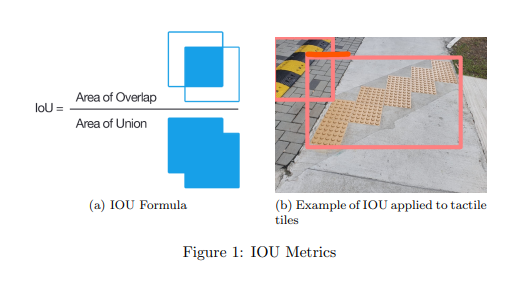

### The Typical Brothers (TP, FP, TN, FN)

Object Detection at its core is a complicated algorithm comprising of both regression and classification. We first define the 4 good brothers that we see in a typical **classification problem**.

Note in usual classification problem, we will have a probabality logit at the end of a softmax/sigmoid layer, which aids us in determining whether a classification belongs to TP, FP, TN or FN.
In object detection, we use the **IOU** to determine if a given a bounding box prediction belongs to the four brothers.

Let us define:

- $\y$: 1 single ground truth bbox;
- $\yhat$: 1 single predicted bbox;
- $\iou(\y, \yhat)$: The IOU between them.
- $t$: The threshold for IOU to cross for it to be a positive, defaults to $0.5$.

Then:

- TP: The model classified it as positive and it indeed is positive; $\yhat$ is TP iff $\iou(\y, \yhat) > t$; both the predictor and the ground truth are in agreement;
- FP: The model classified it as positive but it is negative; $\yhat$ is FP iff $\iou(\y, \yhat) < t$; the predictor raised a false alarm that there is an object but there actually isn't;
- FN: The model classified it as negative but it is positive; $\yhat$ is FN iff there exists a ground truth $\y$ that is not detected by our model;
- TN: This is usually ignored since it means that both the predictor and the annotator ground truth did not have a bounding box; it is often termed as **correct rejections** because there exist infinite places on an image where there are no bounding boxes from both the predictor and the annotator.

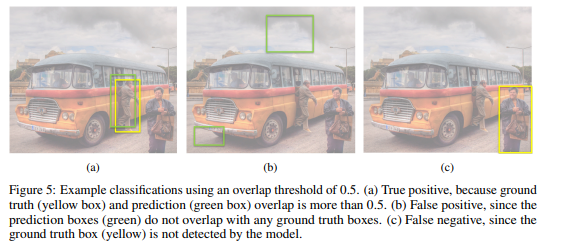

### The Iconic DUO (Precision and Recall)

As with any other classification problem, we will see this iconic duo. Let us recap these 2 metrics in the settings of object detection.

### Precision

> **Precision measures how many of the samples predicted as positive are actually positive. Mathematically, it is expressed as:**

$$
\text{Precision} = \dfrac{\text{TP}}{\text{TP} + \text{FP}}=P(Y=1 | \hat{Y} = 1)
$$

---

> A Probablistic Interpretation
    Notice that the above definition has a probabilitic interpretation $P(Y = 1 | \hat{Y} = 1)$, where $Y$ and $\hat{Y}$ refers to the actual label and predicted labels respectively. We interpreted precision and recall not as ratios but as [estimations of probabilities](https://en.wikipedia.org/wiki/Precision_and_recall).
    Precision is then the estimated probability that a random point selected from the samples are positive. This might be a tough pill to swallow as someone who was never good in statistics but it is just conditional probability. If you try to think a bit further, you can form an intuition as follows:
    > If your classifier $h$ is trained and the last layer is say, sigmoid, which in binary classification, calibrates the logits and turn them into probabilities. Then it can be interpretated that given a randomly chosen point $x \in X_{train}$, what is the probability of this point $x$ to be positive given that it is predicted as positive by the classifer?

---

Informally, precision answers the question **what proportion of positive predictions was actually correct**? In other words, out of all the positive predictions made by the model, how many of those positive predictions were actually positive when compared to the ground truth?

> **In object detection, precision can be throught of as the fraction of correct object predictions among all objects detected by the model**

### Recall

> **Recall measures the following: out of all the actual positives (say, the real cancer patients), how many of them were identified correctly by the classifier? Mathematically, it is expressed as:**
    
$$
\text{Recall}= \dfrac{\text{TP}}{\text{TP} + \text{FN}}= P(\hat{Y}=1 | Y = 1)=1-FNR
$$

From the formula, we see the denominator to be defined as TP + FN, which is unsurprising as this gives you the actual number of positives. The dynamics is also similar to the one in precision.

> **In object detection, recall can be thought of as the fraction of ground truth objects that are correctly detected by the model.**

### Recall vs Precision

The tug of war between this duo is still present, that is to say, as precision goes down, recall might go up and vice versa.

Note that precision and recall are parametrized by the IOU threshold $t$, that means, for each threshold $t$, we can calculate the pair of precision and recall score.

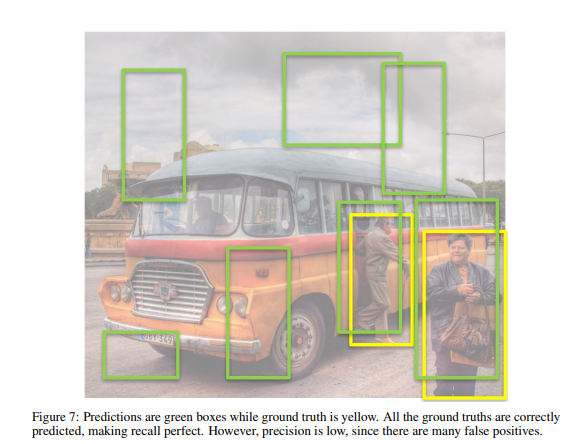

### The Objectness Confidence Score

Before we proceed to the behemoth **Mean Average Precision**, we should take a step back and recall that an usual object detection model is parametrized by:

- predicted bbox: [[...], [...]] 2 predictions;
- associated objectness confidence score: [0.2, 0.9] how confident that the predicted bbox really do contains an object;
- predicted labels: [1, 2]
- associated labels confidence score: [0.3, 0.8] how confident that the predicted label is correct, usually this is the probability logits.

Before we even get to IOU calculation, we have another threshold to worry about, which is the objectness confidence score $\tau$; that is, if the predicted bboxes has confidence score below $\tau$, then we immediately discard the predictions and do not even consider it a valid prediction. So if you are have a high $\tau$ threshold, then you may have a high precision at the cost of low recall. Let us breakdown why:

- If you raise $\tau$, then we have a stringent requirement such that more objects might be missed by the model. A high FN ensues.
- If you decrease $\tau$, then we may have many predictions, say a ground truth image has 2 gt bbox, but since we loosen $\tau$, we have 10 predicted bboxes, this causes a lot of FPs.

> **So a precision recall curve is a plot of precision vs recall at various thresholds $\tau$. Note very carefully that the pr-curve is parametrized by $\tau$ and not $t$ (the IOU threshold).**

### Average Precision

> **The big picture, precison-recall curve can be understood as y = f(x) where y is precision and recall x. More simply, it is just plotting pairs of precision-recall for each threshold $\tau$ and summing the area under the curve.**

> At each confidence level (threshold), we ask what is the precision-recall score of the predictions of **all bounding boxes at a specific IOU** while discarding off those below the threshold, then average them over all thresholds? That's MAP

## Model Architecture

### RCNN

#### Basic Architecture

1. Perform **selective search** to extract multiple high-quality region proposals on the input image. These proposed regions are usually selected at multiple scales with different shapes and sizes. Each region proposal will be labeled with a class and a ground-truth bounding box. *I believe out of the 2000 proposals, some of them won't even enclose any ground truth and so they should be discarded*.
2. Choose a pretrained CNN and truncate it before the output layer. Resize each region proposal to the input size required by the network, and output the extracted features for the region proposal through forward propagation. 
3. Take the extracted features and labeled class of each region proposal as an example. Train multiple support vector machines to classify objects, where each support vector machine individually determines whether the example contains a specific class.
4. Take the extracted features and labeled bounding box of each region proposal as an example. Train a linear regression model to predict the ground-truth bounding box.

![The R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/r-cnn.svg?raw=1)
<div>
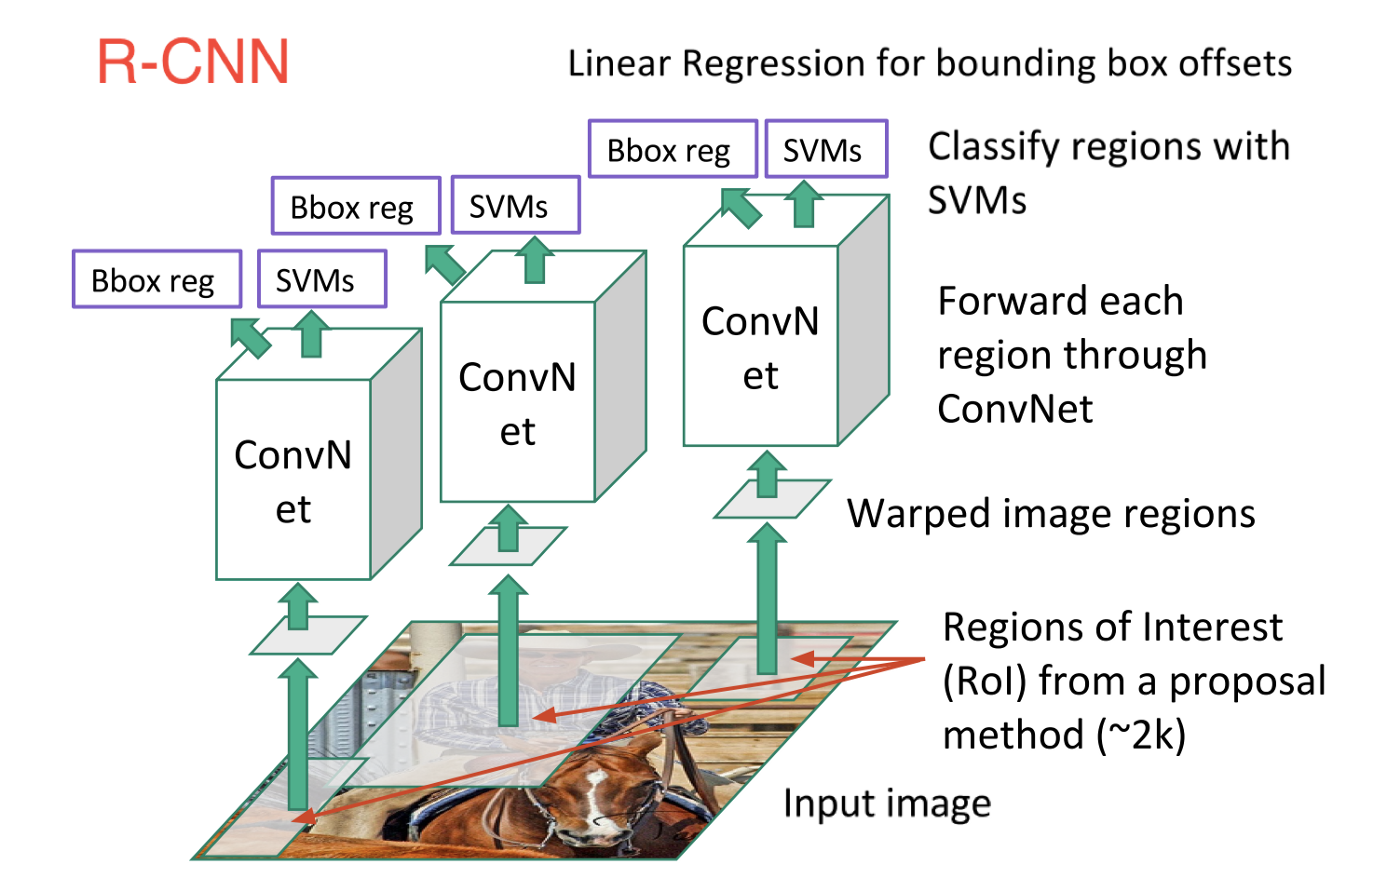
</div>

> **Own words:**

- **Propose say 2000 regions (anchor boxes) then for each of the 2000 regions, we discard the ones with no IOU with ground truth;**
- **Run a CNN on each the remaining region proposals and take the output and:**
    - Feed into SVMs to classify the region;
    - A linear regressor to regress the bboxes;

#### Pros and Cons

**Cons**:
- Too slow as if 2000 proposals need to run 2000 CNNs on it.

### Fast-RCNN

To resolve the 2000 proposals = 2000 CNNs issue, one can envision that we just use 1 CNN for the image and using this 1 CNN we "inference on the 2000 proposals".

#### Basic Architecture

1. Compared with the R-CNN, in the fast R-CNN the input of the CNN for feature extraction is the entire image, rather than individual region proposals. Moreover, this CNN is trainable. Given an input image, let the shape of the CNN output be $1 \times c \times h_1  \times w_1$.
1. Suppose that selective search generates $n$ region proposals. These region proposals (of different shapes) mark regions of interest (of different shapes) on the CNN output. Then these regions of interest further extract features of the same shape (say height $h_2$ and width $w_2$ are specified) in order to be easily concatenated. To achieve this, the fast R-CNN introduces the *region of interest (RoI) pooling* layer: the CNN output and region proposals are input into this layer, outputting concatenated features of shape $n \times c \times h_2 \times w_2$ that are further extracted for all the region proposals.
1. Using a fully-connected layer, transform the concatenated features into an output of shape $n \times d$, where $d$ depends on the model design.
1. Predict the class and bounding box for each of the $n$ region proposals. More concretely, in class and bounding box prediction, transform the fully-connected layer output into an output of shape $n \times q$ ($q$ is the number of classes) and an output of shape $n \times 4$, respectively. The class prediction uses softmax regression.

![The fast R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/fast-rcnn.svg?raw=1)

<div>
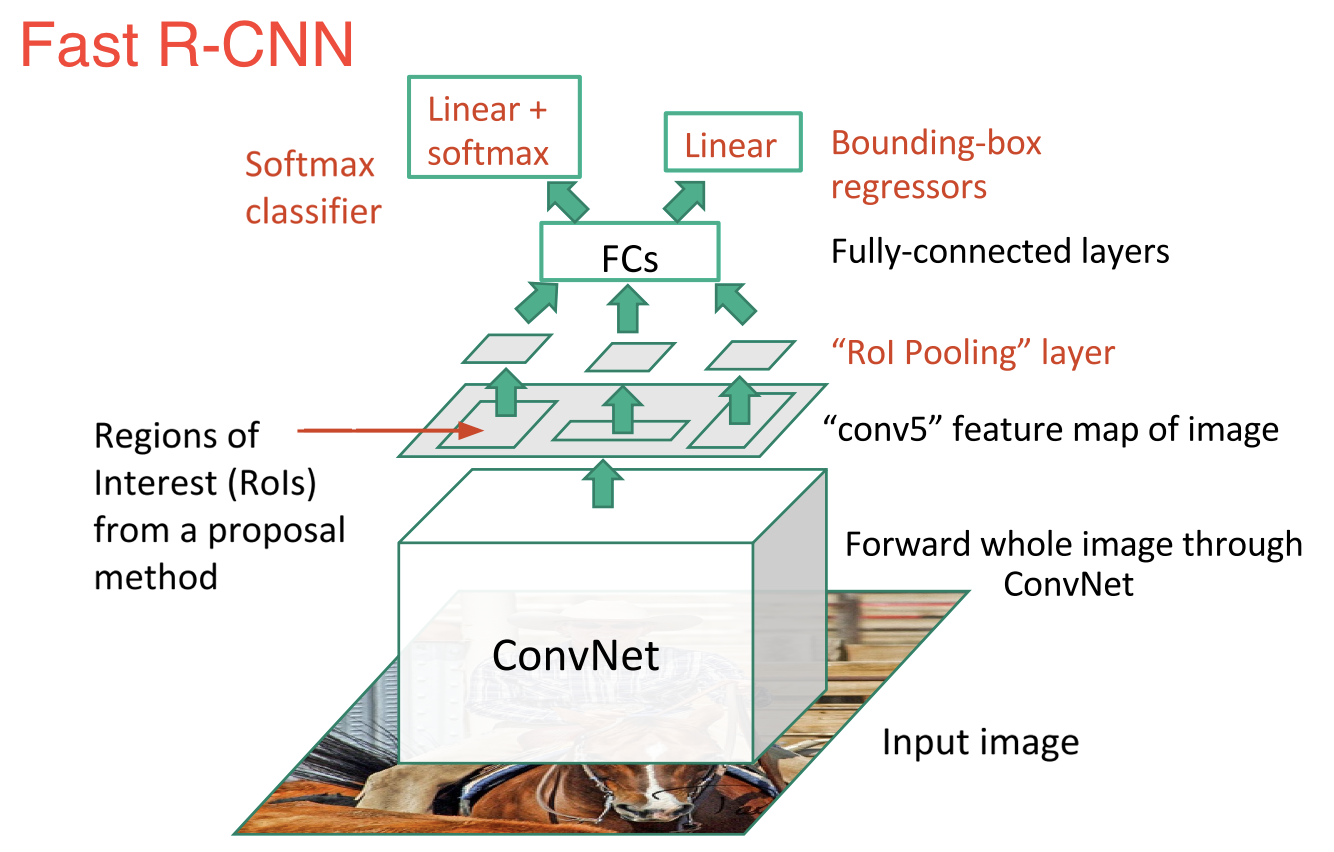
</div>


> **Own words:**

- **Decide on a CNN and truncate head**
- **Here say the CNN output feature map is shape (1, 128, 7, 7) with 128 filters of 7 by 7**
- **Use proposal method to get say n=200 regions**, these regions can be mapped to the CNN output in previous step.
- **Each region can be shaped differently, so we use ROI pooling to shape all n of them into same width and height say 3 by 3. So now our shape is $(200, 128, 3, 3)$ where 200 is stacked region proposals.**
- **Then use the traditional FC with 2 heads to predict**

#### Pros and Cons

**Pros**:
- Solved 2000 CNN issue.

**Cons**:
- Selective search still slow.

### Faster-RCNN

Basically solved selective search with RPN.

#### Basic Architecture


1. Use a $3\times 3$ convolutional layer with padding of 1 to transform the CNN output to a new output with $c$ channels. In this way, each unit along the spatial dimensions of the CNN-extracted feature maps gets a new feature vector of length $c$.
1. Centered on each pixel of the feature maps, generate multiple anchor boxes of different scales and aspect ratios and label them.
1. Using the length-$c$ feature vector at the center of each anchor box, predict the binary class (background or objects) and bounding box for this anchor box.
1. Consider those predicted bounding boxes whose  predicted classes are objects. Remove overlapped results using non-maximum suppression. The remaining  predicted bounding boxes for objects are the region proposals required by the region of interest pooling layer.

![The faster R-CNN model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/faster-rcnn.svg?raw=1)

<div>
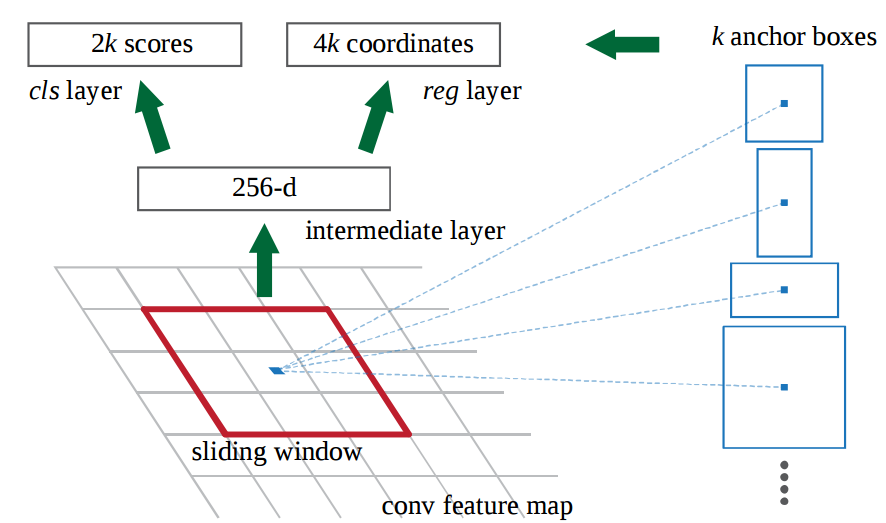
</div>

RPN like this, basically take feature map and connect to 2k and 4k mappings and compare with gt anchor boxes, can be learned so it is powerful and can predict better proposals.

```python
in_channels = 512  # depends on the output feature map. in vgg 16 it is equal to 512

mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)  # I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_();
```

It is worth noting that, as part of the faster R-CNN model, the region proposal network is jointly trained with the rest of the model. In other words, the objective function of the faster R-CNN includes not only the class and bounding box prediction in object detection, but also the binary class and bounding box prediction of anchor boxes in the region proposal network. As a result of the end-to-end training, the region proposal network learns how to generate high-quality region proposals, so as to stay accurate in object detection with a reduced number of region proposals that are learned from data.

#### Pros and Cons

- Still considered 2-stage, accurate but slow.

### Yolo

#### Pros and Cons VS faster rcnn

**Cons**
- Yolo v1 7 by 7 grid, each grid 2 bbox so total 98 bounding boxes.
    - In each grid cell one image is detected even though 2 bounding boxes proposed.
    - This means if objects in an image lie closely in a grid cell then will have issue detecting all of them.
    - It doesn’t generalize well when objects in the image show rare aspects of ratio.

- Faster RCNN on the other hand, do detect small objects well since it has nine anchors in a single grid, however it fails to do real-time detection with its two step architecture cause too slow.

#### Yolo V3

While YOLOv2 uses the DarkNet-19 as the model architecture, YOLOv3 uses a much more complex DarkNet-53 as the model backbone— a 106 layer neural network complete with residual blocks and upsampling networks.

YOLOv3’s architectural novelty allows it to predict at 3 different scales, with the feature maps being extracted at layers 82, 94, and 106 for these predictions..

By detecting features at 3 different scales, YOLOv3 makes up for the shortcomings of YOLOv2 and YOLO, particularly in the detection of smaller objects. With the architecture allowing the concatenation of the upsampled layer outputs with the features from previous layers, the fine-grained features that have been extracted are preserved thus making the detection of smaller objects easier.

YOLOv3 only predicts 3 bounding boxes per cell (compared to 5 in YOLOv2) but it makes three predictions at different scales, totaling up to 9 anchor boxes.

#### Screenshots

<div>
<img src="https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/LTA/images/yolov1_vs_fasterrcnn.PNG" width="800"/>
</div>

<div>
<img src="https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/LTA/images/yolov123_comparison.PNG" width="800"/>
</div>

## Augmentations

- Augmentation techniques. This helps artificially expanding the dataset, intuition is in each training iteration (batch), the model sees a slightly different version of the original image, and thus helps to generalize.
        - Normal flips and rotational geometrical transformation, that is a given since photos can be upside down, left-right flipped.
        - Hue, Saturation and Color to match dusk, noon and dawn.
        - Random Eraser, similar to dropout, we mask certain parts of the image to force the model to learn with less information, a regularization to overfitting and memorization.